## Подготовка данных

Импортируем библиотеки которые понадобятся или могут быть полезны.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pylab as pl
import time

from tqdm.notebook import trange, tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV, cross_val_score
from scipy import stats as st
from scipy.spatial import distance

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor

from catboost import CatBoostRegressor
import lightgbm as lgb

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics.scorer import make_scorer


import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('/datasets/autos.csv')

In [ ]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


**Признаки**  

- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- NotRepaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

**Целевой признак**  

- Price — цена (евро)

Глянем на распределение столбцов.

In [ ]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


НАблюдаем аномалии:
- Цена имеет значение 0.
- Год регистрации авто 1000 год и 9999 год.
- Мощность имеет 0 и 20000 л.с. .

Проверим пропуски и дубликаты.

In [ ]:
df.duplicated().sum()

4

Удалим дубликаты.

In [ ]:
df = df.drop_duplicates().reset_index(drop=True)

In [ ]:
df.isna().mean()

DateCrawled          0.000000
Price                0.000000
VehicleType          0.105795
RegistrationYear     0.000000
Gearbox              0.055968
Power                0.000000
Model                0.055607
Kilometer            0.000000
RegistrationMonth    0.000000
FuelType             0.092828
Brand                0.000000
NotRepaired          0.200793
DateCreated          0.000000
NumberOfPictures     0.000000
PostalCode           0.000000
LastSeen             0.000000
dtype: float64

Наблюдайем процент пропусков:  

- Тип кузова - 10.58%
- Тип коробки передач - 5.6%
- Модель авто - 5.56%
- Тип топлива - 9%
- Наличие ремонта - 20%

ПРоверим типы данных.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354365 entries, 0 to 354364
Data columns (total 16 columns):
DateCrawled          354365 non-null object
Price                354365 non-null int64
VehicleType          316875 non-null object
RegistrationYear     354365 non-null int64
Gearbox              334532 non-null object
Power                354365 non-null int64
Model                334660 non-null object
Kilometer            354365 non-null int64
RegistrationMonth    354365 non-null int64
FuelType             321470 non-null object
Brand                354365 non-null object
NotRepaired          283211 non-null object
DateCreated          354365 non-null object
NumberOfPictures     354365 non-null int64
PostalCode           354365 non-null int64
LastSeen             354365 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


Видим, что столбцы "DateCrawled", "DateCreated", 'LastSeen' с датой и временем имеют неправильный тип данных. Исправим

In [ ]:
df[["DateCrawled", "DateCreated", 'LastSeen']] = df[
    ["DateCrawled", "DateCreated", 'LastSeen']].apply(pd.to_datetime, format='%Y-%m-%dT%H:%M:%S')

Заменим пропуски на "unknown".

In [ ]:
df = df.fillna('unknown')

Разберемся с аномалиями. Посмотрим на них

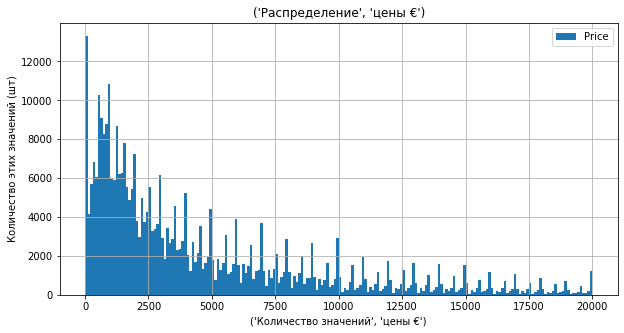

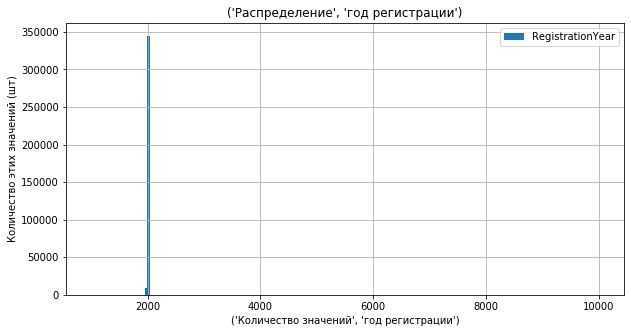

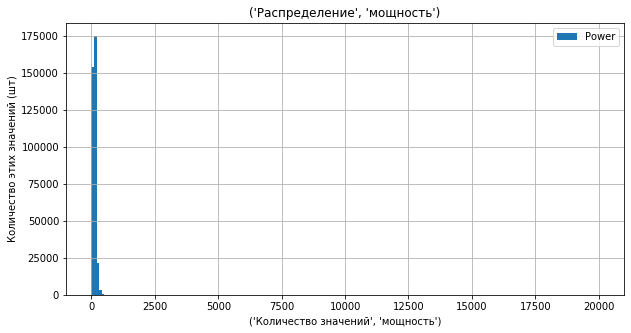

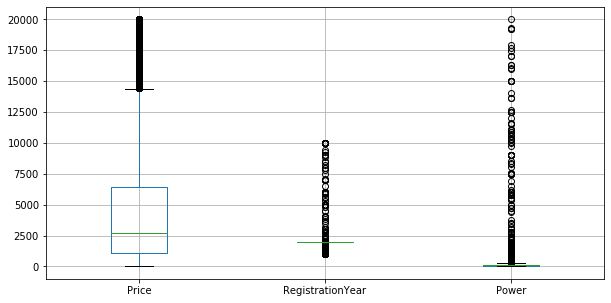

In [ ]:
values = ['Price', 'RegistrationYear', "Power"]
names = ['цены €', 'год регистрации', 'мощность']
for i in range(len(values)):
    plt.figure(figsize=(10,5))
    df[values[i]].plot.hist(bins=200, legend=True, grid=True)
    plt.title(('Распределение', names[i]))
    plt.xlabel(('Количество значений', names[i]))
    plt.ylabel('Количество этих значений (шт)')
    plt.show()
    
df[values].boxplot(figsize=(10,5))
plt.show()

Видим много аномалий. Обрежим года регистрации авто, мощность и цену, чтобы привести данные в норму, т.к. многих значений просто не может быть в реальности. К примеру 1000 год н.э. регистрации авто.

In [ ]:
df = df.query("Power >= 50 and Power <= 1000")

ПРоверим по дате скачивания базы данных послдений год и от этого будет зависить как в будущем мы будем резать гор регистрации авто.

In [ ]:
df.DateCrawled.max()

Timestamp('2016-04-07 14:36:58')

In [ ]:
df = df.query("RegistrationYear >= 1930 and RegistrationYear <= 2016")

Посмотрим как у нас идет рост денег до 1000€ после того, как мы убрали аномалии в годах регистрации и мощности.

In [ ]:
for i in range(5):
    begin = i * 100
    end = begin + 100
    value = df.query('Price <= 1000')['Price'].value_counts().index.sort_values()[begin:end]
    print(value)

Int64Index([  0,   1,   2,   3,   5,   9,  10,  11,  12,  13,  15,  17,  20,
             24,  25,  26,  29,  30,  35,  38,  39,  40,  45,  47,  49,  50,
             55,  60,  65,  66,  69,  70,  75,  77,  79,  80,  85,  89,  90,
             95,  98,  99, 100, 101, 105, 108, 110, 111, 112, 115, 117, 119,
            120, 122, 123, 125, 126, 128, 129, 130, 132, 133, 135, 139, 140,
            142, 145, 149, 150, 155, 156, 157, 159, 160, 162, 165, 166, 169,
            170, 173, 175, 179, 180, 181, 185, 188, 189, 190, 192, 193, 195,
            196, 198, 199, 200, 202, 205, 209, 210, 211],
           dtype='int64')
Int64Index([215, 217, 219, 220, 222, 224, 225, 229, 230, 233, 235, 236, 240,
            243, 245, 248, 249, 250, 251, 252, 253, 255, 259, 260, 261, 263,
            265, 266, 269, 270, 272, 273, 274, 275, 277, 278, 279, 280, 281,
            284, 285, 289, 290, 295, 298, 299, 300, 301, 305, 308, 309, 310,
            315, 316, 319, 320, 321, 323, 325, 329, 330, 331, 332, 33

Видим, что рост цены у нас плавный. У меня нет под рукой бизнес менеджера который скажет поо сколько мне резать цену. Если у нас модель которая предсказывает цену авто, то отрежим по 100€. 

In [ ]:
df = df.query("Price >= 100")

In [ ]:
df.reset_index(drop=True, inplace=True)

# Вывод:

Мы сделали предобработку данных. У нас были пропуски к категорях которые мы заменили на "unknown". Удалили дубликаты. НАшли аномалии и привели наши данные в норму.

## Обучение моделей

Сделаем копию основного датасета для проверки на алгоритмах бустинга. Далее проверим на обычных алгоритмах с кодированием признаков классификации.

In [ ]:
df_copy = df.copy()

РАзделим на признаки и целевой. Удалим ненужные признаки.

In [ ]:
features_copy = df_copy.drop(['DateCrawled', 'Price', 'RegistrationMonth',
                              'DateCreated', 'NumberOfPictures', 'PostalCode','LastSeen'], axis=1)
target_copy = df_copy['Price']

In [ ]:
cat_features = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']
for i in cat_features:
    features_copy[i] = features_copy[i].astype('category')

Разделим на выборки.

In [ ]:
features_train_c, features_test_c, target_train_c, target_test_c = train_test_split(
    features_copy, target_copy, random_state=12345, test_size=0.3)
features_train_c.shape, features_test_c.shape

((203030, 9), (87014, 9))

In [ ]:
features_train_c.head()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
208664,wagon,2005,manual,133,stilo,150000,petrol,fiat,no
115677,sedan,1998,manual,125,passat,150000,petrol,volkswagen,no
140438,bus,2013,manual,122,tiguan,60000,petrol,volkswagen,no
141167,coupe,1991,manual,54,polo,150000,petrol,volkswagen,no
217747,sedan,1997,manual,125,a4,150000,petrol,audi,unknown


Обучим CatBoost.

In [ ]:
%%time
model_cat = CatBoostRegressor(loss_function='RMSE', random_seed=12345, cat_features=cat_features)

grid = {'iterations' : [150],
        'learning_rate' : [0.4, 0.5],
        'depth': [8, 10]
       }

results = model_cat.grid_search(grid, X=features_train_c, y=target_train_c, cv=3)

0:	loss: 1570.5963859	best: 1570.5963859 (0)	total: 52.7s	remaining: 2m 38s
1:	loss: 1567.7659993	best: 1567.7659993 (1)	total: 1m 42s	remaining: 1m 42s
2:	loss: 1540.5493781	best: 1540.5493781 (2)	total: 2m 40s	remaining: 53.7s
3:	loss: 1543.8886816	best: 1540.5493781 (2)	total: 3m 40s	remaining: 0us
Estimating final quality...
CPU times: user 6min 42s, sys: 43.3 s, total: 7min 25s
Wall time: 7min 35s


In [ ]:
print(model_cat.get_best_score(), model_cat.get_params(), sep='\n\n')

{'learn': {'RMSE': 1386.0136773607353}}

{'loss_function': 'RMSE', 'random_seed': 12345, 'cat_features': ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired'], 'depth': 10, 'iterations': 150, 'learning_rate': 0.4}


In [ ]:
%%time
model_cat.fit(features_train_c, target_train_c, verbose=100)

0:	learn: 3380.3109910	total: 457ms	remaining: 1m 8s
100:	learn: 1432.7354019	total: 46.9s	remaining: 22.8s
149:	learn: 1386.0136774	total: 1m 9s	remaining: 0us
CPU times: user 1min 3s, sys: 5.67 s, total: 1min 9s
Wall time: 1min 12s


In [ ]:
%%time
predictions = model_cat.predict(features_test_c)

CPU times: user 237 ms, sys: 9.85 ms, total: 247 ms
Wall time: 228 ms


In [ ]:
score_cat = mean_squared_error(target_test_c, predictions) ** 0.5
score_cat

1576.7341339144757

При использовании модели CatBoost я использовал след. гиперпаарметры:
- loss function = RMSE (Минимизировал наше ошибку по RMSE)
- iterations - количество итераций которая совершает наша модель.
- random_seed - используем этот гиперпараметр для воспроизводимости теста.
- cat_features - категориальные признаки для кодирования.
- leaning rate - это скорость обучения или шаг. Гиперпараметр помогающий регулировать наш спуск делая его плавнее или быстрее.
- depth - глубина дерева.
- cv - количество разбиений на кросс-валидацию.

Лушчую метрику RMSE на обучении модели мы получили 1386. На тесте у нас RMSE 1576.

Обучим LinearRegression.  

Закодируем категориальные признаки. Потом разделим на признаки и таргет. Поделим на выборки. Сделаем стандартизацию и обучим модель.

In [ ]:
df_ohe = pd.get_dummies(df, drop_first=True)

In [ ]:
features = df_ohe.drop(['DateCrawled', 'Price', 'RegistrationMonth', 
                        'DateCreated', 'NumberOfPictures', 'PostalCode','LastSeen'], axis=1)
target = df_ohe['Price']

In [ ]:
features_train, features_test, target_train, target_test = train_test_split(
                                                features, target, random_state=12345, test_size=0.3)
features_train.shape, features_test.shape

((203030, 310), (87014, 310))

In [ ]:
numeric = ['RegistrationYear', 'Power', 'Kilometer']
scaler = StandardScaler()
scaler.fit(features_train[numeric])

StandardScaler(copy=True, with_mean=True, with_std=True)

In [ ]:
features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

In [ ]:
%%time
model_linear = LinearRegression()
model_linear.fit(features_train, target_train)

CPU times: user 18.3 s, sys: 10.4 s, total: 28.7 s
Wall time: 28.7 s


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
%%time
predictions = model_linear.predict(features_test)

CPU times: user 100 ms, sys: 103 ms, total: 203 ms
Wall time: 194 ms


In [ ]:
score_linear = mean_squared_error(target_test, predictions) ** 0.5
score_linear

2593.285942441118

Метрика RMSE на линейной регрессии у нас 2593.

Проверим на адекватность нашу модель.

In [ ]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(features_train, target_train)
predictions_dummy = dummy_regr.predict(features_test)

In [ ]:
mean_squared_error(target_test, predictions_dummy) ** 0.5

4639.373240379905

Видим, что наша модель предсказывает лучше, чем RMSE по среднему. 

Обучим LGBM

In [ ]:
features_train_c.head(1)

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
208664,wagon,2005,manual,133,stilo,150000,petrol,fiat,no


In [ ]:
lgb_train = lgb.Dataset(features_train_c, target_train_c, categorical_feature=cat_features)

params = {
    'objective' : 'regression',
    'metric' : 'rmse',
    'max_depth' : 10,
    'learning_rate' : 0.5,
    'random_state' : 12345
         }

In [ ]:
%%time
booster = lgb.train(params,
                    lgb_train,
                    num_boost_round=150,
                    verbose_eval=100)

CPU times: user 5min 57s, sys: 1.37 s, total: 5min 58s
Wall time: 6min 1s


In [ ]:
%%time
predictions = booster.predict(features_test_c)

CPU times: user 1.21 s, sys: 0 ns, total: 1.21 s
Wall time: 1.16 s


In [ ]:
score_lgbm = mean_squared_error(target_test_c, predictions) ** 0.5
score_lgbm

1581.7363418074438

При использовании LGBM использовали след. гиперпаарметры:

- objective - тип модели
- metric - мерика
- max_depth - глубина дерева
- learning_rate - шаг
- random_state - воспроизводимость

RMSE метрика на тесте 1589.

## Анализ моделей

In [ ]:
pd.DataFrame(data={'score RMSE': [int(score_cat), int(score_linear), int(score_lgbm)],
                   'time training': ['≈ 1min 10s', '≈ 22.4 s', '≈ 10.5 s'],
                   'predictions speed': ['≈ 350 ms', '≈ 196 ms', '≈ 1.69 s']
                  }, index=['CatBoost', 'LinearRegressor', 'LGBM'])

,score RMSE,time training,predictions speed
CatBoost,1576,≈ 1min 10s,≈ 350 ms
LinearRegressor,2593,≈ 22.4 s,≈ 196 ms
LGBM,1581,≈ 10.5 s,≈ 1.69 s


Видим, что алгоритм LGBM лучше всех справляется с поставленными задачами: лучше всех местрика, лучше время обучения и не так сильно отличается скорость предсказания.

# Общий вывод:

Провели общую предобработку данных с заменой пропусков и с удалением аномалий. Обучили несколько моделей и проверили результат. В итоге модель LGBM оказалась лучше по большенству параметров.